In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
train_df = pd.read_csv('/content/drive/My Drive/Analytics_Vidhya/train.csv')
test_df = pd.read_csv('/content/drive/My Drive/Analytics_Vidhya/test.csv')
transaction_df = pd.read_csv('/content/drive/My Drive/Analytics_Vidhya/transactions.csv')
sample_df = pd.read_csv('/content/drive/My Drive/Analytics_Vidhya/sample_submission.csv')

In [3]:
print(train_df.head())

          doj  srcid  destid  final_seatcount
0  2023-03-01     45      46           2838.0
1  2023-03-01     46      45           2298.0
2  2023-03-01     45      47           2720.0
3  2023-03-01     47      45           2580.0
4  2023-03-01     46       9           4185.0


In [4]:
print(test_df.head())

          route_key         doj  srcid  destid
0  2025-02-11_46_45  2025-02-11     46      45
1  2025-01-20_17_23  2025-01-20     17      23
2  2025-01-08_02_14  2025-01-08      2      14
3  2025-01-08_08_47  2025-01-08      8      47
4  2025-01-08_09_46  2025-01-08      9      46


In [5]:
print(transaction_df.head())

          doj         doi  srcid  destid    srcid_region   destid_region  \
0  2023-03-01  2023-01-30     45      46       Karnataka      Tamil Nadu   
1  2023-03-01  2023-01-30     46      45      Tamil Nadu       Karnataka   
2  2023-03-01  2023-01-30     45      47       Karnataka  Andhra Pradesh   
3  2023-03-01  2023-01-30     47      45  Andhra Pradesh       Karnataka   
4  2023-03-01  2023-01-30     46       9      Tamil Nadu      Tamil Nadu   

  srcid_tier destid_tier  cumsum_seatcount  cumsum_searchcount  dbd  
0     Tier 1      Tier 1               8.0                76.0   30  
1     Tier 1      Tier 1               8.0                70.0   30  
2     Tier 1      Tier 1               4.0               142.0   30  
3     Tier 1      Tier 1               0.0                68.0   30  
4     Tier 1       Tier2               9.0               162.0   30  


In [6]:
print(sample_df.head())

          route_key  final_seatcount
0  2025-02-11_46_45                0
1  2025-01-20_17_23                0
2  2025-01-08_02_14                0
3  2025-01-08_08_47                0
4  2025-01-08_09_46                0


In [7]:
print(train_df.shape)
print(test_df.shape)
print(transaction_df.shape)
print(sample_df.shape)

(67200, 4)
(5900, 4)
(2266100, 11)
(5900, 2)


In [8]:
import numpy as np

# Only keep needed dbd
seq_dbd = list(range(1, 16))
transactions_filt = transaction_df[transaction_df['dbd'].isin(seq_dbd)]

# Prepare pivot table to quickly fetch historical values as columns
pivot = transactions_filt.pivot_table(
    index=['srcid', 'destid', 'doj'],
    columns='dbd',
    values=['cumsum_seatcount', 'cumsum_searchcount'],
    fill_value=0
)
pivot.columns = [f"{v}_dbd{dbd}" for v, dbd in pivot.columns] # Flatten columns

pivot.reset_index(inplace=True)

df = pd.merge(train_df, pivot, how='left', on=['srcid', 'destid', 'doj'])
# Collect feature columns in correct sequence order
seq_cols = []
for feat in ['cumsum_seatcount', 'cumsum_searchcount']:
    seq_cols += [f"{feat}_dbd{dbd}" for dbd in range(15, 0, -1)]

# Shape into 3D array for LSTM: (samples, timesteps, features)
X_raw  = df[seq_cols].values.reshape(len(df), 15, 2)
y = df['final_seatcount'].values

In [9]:
from sklearn.model_selection import train_test_split

X_train_raw, X_val_raw, y_train, y_val = train_test_split(
    X_raw, y, test_size=0.2, shuffle=False
)

In [10]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_2d = X_train_raw.reshape(-1, X_train_raw.shape[2])
X_val_2d = X_val_raw.reshape(-1, X_val_raw.shape[2])

scaler.fit(X_train_2d)
X_train_scaled = scaler.transform(X_train_2d).reshape(X_train_raw.shape)
X_val_scaled = scaler.transform(X_val_2d).reshape(X_val_raw.shape)

In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import keras

SEQUENCE_LENGTH = 15
model = Sequential([
    LSTM(50, input_shape=(SEQUENCE_LENGTH, 2), activation='relu', return_sequences=False),
    Dropout(0.2),
    Dense(1)  # Regression output
])
opt = keras.optimizers.Adam(learning_rate=0.001)

model.compile(optimizer=opt, loss='mean_squared_error')

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [12]:
from keras.callbacks import ModelCheckpoint
epochs = 30
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.from_scratch_15.keras',
                            verbose=1, save_best_only=True)

history = model.fit(X_train_scaled, y_train, validation_data=(X_val_scaled, y_val), epochs=epochs, batch_size=32, callbacks=[checkpointer], verbose=1)
print("Model training complete.")

Epoch 1/30
1677/1680 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1684868.3750
Epoch 1: val_loss improved from inf to 978313.62500, saving model to saved_models/weights.best.from_scratch_15.keras
1680/1680 ━━━━━━━━━━━━━━━━━━━━ 26s 11ms/step - loss: 1683277.3750 - val_loss: 978313.6250
Epoch 2/30
1680/1680 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 625037.3750
Epoch 2: val_loss improved from 978313.62500 to 626039.00000, saving model to saved_models/weights.best.from_scratch_15.keras
1680/1680 ━━━━━━━━━━━━━━━━━━━━ 16s 10ms/step - loss: 624999.0625 - val_loss: 626039.0000
Epoch 3/30
1677/1680 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 480113.8750
Epoch 3: val_loss improved from 626039.00000 to 472917.09375, saving model to saved_models/weights.best.from_scratch_15.keras
1680/1680 ━━━━━━━━━━━━━━━━━━━━ 20s 9ms/step - loss: 480041.2812 - val_loss: 472917.0938
Epoch 4/30
1676/1680 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 347783.0625
Epoch 4: val_loss improved from 472917.09375 to 416970.37500, savi

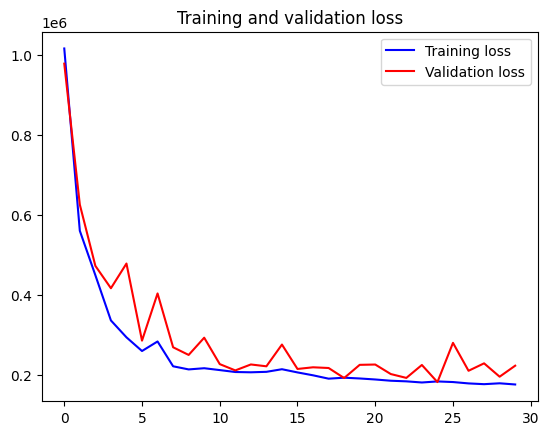

In [13]:
model.load_weights('saved_models/weights.best.from_scratch_15.keras')
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(epochs)
plt.figure()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [14]:
from sklearn.metrics import mean_squared_error

# Make predictions on training and validation data
y_train_pred = model.predict(X_train_scaled)
y_val_pred = model.predict(X_val_scaled)

# Calculate RMSE
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))

# Calculate Normalized RMSE
normalized_rmse_train = train_rmse / np.mean(y_train)
normalized_rmse_valid = val_rmse / np.mean(y_val)

print(f"Training RMSE: {train_rmse:.2f}")
print(f"Validation RMSE: {val_rmse:.2f}")
print(f"Training Normalized RMSE: {normalized_rmse_train:.2f}")
print(f"Validation Normalized RMSE: {normalized_rmse_valid:.2f}")

1680/1680 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step
420/420 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Training RMSE: 352.57
Validation RMSE: 427.08
Training Normalized RMSE: 0.18
Validation Normalized RMSE: 0.19


In [15]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint
import keras

SEQUENCE_LENGTH = 15
model_gru = Sequential([
    GRU(50, input_shape=(SEQUENCE_LENGTH, 2), activation='relu', return_sequences=False),
    Dropout(0.2),
    Dense(1)  # Regression output
])
opt_gru = keras.optimizers.Adam(learning_rate=0.001)

model_gru.compile(optimizer=opt_gru, loss='mean_squared_error')

epochs = 30
checkpointer_gru = ModelCheckpoint(filepath='saved_models/weights.best.from_scratch_gru_15.keras',
                                   verbose=1, save_best_only=True)

history_gru = model_gru.fit(X_train_scaled, y_train, validation_data=(X_val_scaled, y_val),
                            epochs=epochs, batch_size=32, callbacks=[checkpointer_gru], verbose=1)

print("GRU model training complete.")

Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1677/1680 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1831408.3750
Epoch 1: val_loss improved from inf to 959023.00000, saving model to saved_models/weights.best.from_scratch_gru_15.keras
1680/1680 ━━━━━━━━━━━━━━━━━━━━ 19s 10ms/step - loss: 1829879.7500 - val_loss: 959023.0000
Epoch 2/30
1678/1680 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 735516.6875
Epoch 2: val_loss improved from 959023.00000 to 708708.18750, saving model to saved_models/weights.best.from_scratch_gru_15.keras
1680/1680 ━━━━━━━━━━━━━━━━━━━━ 17s 10ms/step - loss: 735402.2500 - val_loss: 708708.1875
Epoch 3/30
1677/1680 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 547161.0625
Epoch 3: val_loss improved from 708708.18750 to 576801.75000, saving model to saved_models/weights.best.from_scratch_gru_15.keras
1680/1680 ━━━━━━━━━━━━━━━━━━━━ 20s 10ms/step - loss: 547138.0000 - val_loss: 576801.7500
Epoch 4/30
1680/1680 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 471550.3125
Epoch 4: val_loss did not improve from 576801.75000
1680/1680 ━━━

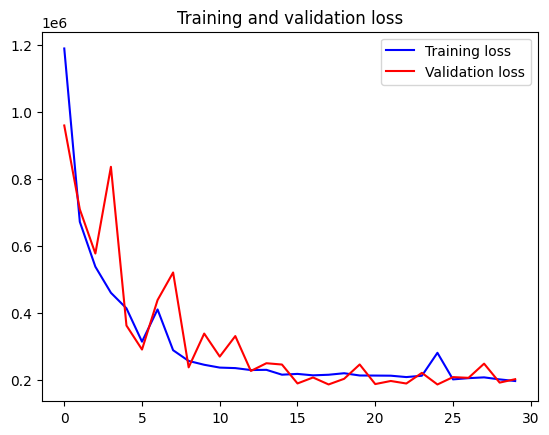

In [16]:
model_gru.load_weights('saved_models/weights.best.from_scratch_gru_15.keras')
import matplotlib.pyplot as plt

loss = history_gru.history['loss']
val_loss = history_gru.history['val_loss']

epochs = range(epochs)
plt.figure()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [17]:
# Make predictions on training and validation data
y_train_pred = model_gru.predict(X_train_scaled)
y_val_pred = model_gru.predict(X_val_scaled)

# Calculate RMSE
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))

# Calculate Normalized RMSE
normalized_rmse_train = train_rmse / np.mean(y_train)
normalized_rmse_valid = val_rmse / np.mean(y_val)

print(f"Training RMSE: {train_rmse:.2f}")
print(f"Validation RMSE: {val_rmse:.2f}")
print(f"Training Normalized RMSE: {normalized_rmse_train:.2f}")
print(f"Validation Normalized RMSE: {normalized_rmse_valid:.2f}")

1680/1680 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step
420/420 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
Training RMSE: 354.13
Validation RMSE: 431.14
Training Normalized RMSE: 0.18
Validation Normalized RMSE: 0.19


In [18]:
SEQ_LEN = 15
model_lstm_2 = Sequential([
    LSTM(50, return_sequences=True, activation='relu', input_shape=(SEQ_LEN, X_train_scaled.shape[2])),
    Dropout(0.3),
    LSTM(50, activation='relu'),
    Dropout(0.3),
    Dense(32, activation='relu', kernel_regularizer='l2'),
    Dense(1)
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [20]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.from_scratch_2_lstm.keras',
                            verbose=1, save_best_only=True)
epochs = 30
callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4),
    EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True),
    checkpointer
]
opt_lstm = keras.optimizers.Adam(learning_rate=0.001)

model_lstm_2.compile(optimizer=opt_lstm, loss='mean_squared_error')
history = model_lstm_2.fit(X_train_scaled, y_train, validation_data=(X_val_scaled, y_val), epochs=epochs, batch_size=32, callbacks=[callbacks], verbose=1)
print("Model training complete.")

Epoch 1/30
1679/1680 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1459172.1250
Epoch 1: val_loss improved from inf to 1064456.00000, saving model to saved_models/weights.best.from_scratch_2_lstm.keras
1680/1680 ━━━━━━━━━━━━━━━━━━━━ 33s 17ms/step - loss: 1458538.6250 - val_loss: 1064456.0000 - learning_rate: 0.0010
Epoch 2/30
1680/1680 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 572290.1875
Epoch 2: val_loss improved from 1064456.00000 to 592921.87500, saving model to saved_models/weights.best.from_scratch_2_lstm.keras
1680/1680 ━━━━━━━━━━━━━━━━━━━━ 29s 17ms/step - loss: 572243.3750 - val_loss: 592921.8750 - learning_rate: 0.0010
Epoch 3/30
1678/1680 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 367591.3438
Epoch 3: val_loss did not improve from 592921.87500
1680/1680 ━━━━━━━━━━━━━━━━━━━━ 43s 18ms/step - loss: 367556.6875 - val_loss: 598568.6875 - learning_rate: 0.0010
Epoch 4/30
1680/1680 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 1035381.8750
Epoch 4: val_loss improved from 592921.87500 to 4124